In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting
from numpy import pi
import ephem
from tqdm import tqdm
import reverse_geocoder as rg
from collections import Counter
import networkx as nx
from multiprocessing import Pool
from scipy import sparse, stats, spatial
from pygsp import graphs, filters, plotting

import seaborn as sns

plt.rcParams['figure.figsize'] = (17, 5)
plotting.BACKEND = 'matplotlib'

## SATCAT launch site analysis 

### SATCAT data extraction and exploration

#### Extract celestrack SATCAT data

In [2]:
operational_status_dict = {}
operational_status_dict["+"] = "Operational"
operational_status_dict["-"] = "Nonoperational"
operational_status_dict["P"] = "Partially Operational"
operational_status_dict["B"] = "Backup/Standby"
operational_status_dict["S"] = "Spare"
operational_status_dict["X"] = "Extended Mission"
operational_status_dict["D"] = "Decayed"
operational_status_dict["?"] = "Unknown"
operational_status_dict[" "] = "Unknown"

In [3]:
def extract_dict(line):
    """This function extract the informations from satcat dataset"""
    
    sat_info_dict = {}
    try:
        sat_info_dict["launch_year"] = int(line[0:4])
        sat_info_dict["launch_nbr"] = int(line[5:8])
        sat_info_dict["launch_piece"] = line[8:11]
        sat_info_dict["NORAD"] = int(line[13:18])
        sat_info_dict["multiple_name_flag"] =  True if line[19] == "M" else False 
        sat_info_dict["payload_flag"] = True if line[20] == "*" else False 
        sat_info_dict["operational_status"] = operational_status_dict[line[21]]
        sat_info_dict["name"] = line[23:47].strip() 
        sat_info_dict["source"] = line[49:54].strip()
        sat_info_dict["launch_date"] = line[56:66].strip()
        sat_info_dict["launch_site"] = line[68:73].strip()
        sat_info_dict["decay_date"] = line[75:85].strip()
        sat_info_dict["orbital_period"] = float(line[87:94])
        sat_info_dict["inclination"] = float(line[96:101]) 
        sat_info_dict["apogee"] = float(line[103:109])
        sat_info_dict["perigee"] = float(line[111:117])
        sat_info_dict["radar_cross_section"] = float(line[119:127]) if line[119:127].strip() != "N/A" else None 
        sat_info_dict["orbital_status"] = "EA" if line[129:132].strip() == '' else line[129:132].strip()
    # If there's an error, incomplete line for example, we thrash it
    except (IndexError, ValueError) as e:
        return None
    return sat_info_dict

In [4]:
sat_info_array = []
with open('Dataset/satcat.txt') as f:
    bad_data_count = 0
    for line in tqdm(f):
        local_sat_info_dict = extract_dict(line)
        if local_sat_info_dict:
            sat_info_array.append(local_sat_info_dict)
        else:
            bad_data_count +=1

43165it [00:00, 166916.18it/s]


In [5]:
print("Bad data: {}\nGood data: {}".format(bad_data_count, len(sat_info_array)))

Bad data: 1256
Good data: 41909


In [6]:
satcat_df = pd.DataFrame(sat_info_array)
satcat_df = satcat_df.set_index("NORAD")
display(satcat_df.head(5))

,apogee,decay_date,inclination,launch_date,launch_nbr,launch_piece,launch_site,launch_year,multiple_name_flag,name,operational_status,orbital_period,orbital_status,payload_flag,perigee,radar_cross_section,source
NORAD,,,,,,,,,,,,,,,,,
1,938.0,1957-12-01,65.1,1957-10-04,1,A,TYMSC,1957,False,SL-1 R/B,Decayed,96.2,EA,False,214.0,20.420,CIS
2,945.0,1958-01-03,65.0,1957-10-04,1,B,TYMSC,1957,False,SPUTNIK 1,Decayed,96.1,EA,True,227.0,NaN,CIS
3,1659.0,1958-04-14,65.3,1957-11-03,2,A,TYMSC,1957,False,SPUTNIK 2,Decayed,103.7,EA,True,211.0,0.080,CIS
4,215.0,1970-03-31,33.2,1958-02-01,1,A,AFETR,1958,False,EXPLORER 1,Decayed,88.5,EA,True,183.0,NaN,US
5,3834.0,,34.3,1958-03-17,2,B,AFETR,1958,False,VANGUARD 1,Unknown,132.8,EA,True,650.0,0.122,US


#### Fill NaN

In [7]:
satcat_df = satcat_df.fillna(value=0)
display(satcat_df.head(5))

,apogee,decay_date,inclination,launch_date,launch_nbr,launch_piece,launch_site,launch_year,multiple_name_flag,name,operational_status,orbital_period,orbital_status,payload_flag,perigee,radar_cross_section,source
NORAD,,,,,,,,,,,,,,,,,
1,938.0,1957-12-01,65.1,1957-10-04,1,A,TYMSC,1957,False,SL-1 R/B,Decayed,96.2,EA,False,214.0,20.420,CIS
2,945.0,1958-01-03,65.0,1957-10-04,1,B,TYMSC,1957,False,SPUTNIK 1,Decayed,96.1,EA,True,227.0,0.000,CIS
3,1659.0,1958-04-14,65.3,1957-11-03,2,A,TYMSC,1957,False,SPUTNIK 2,Decayed,103.7,EA,True,211.0,0.080,CIS
4,215.0,1970-03-31,33.2,1958-02-01,1,A,AFETR,1958,False,EXPLORER 1,Decayed,88.5,EA,True,183.0,0.000,US
5,3834.0,,34.3,1958-03-17,2,B,AFETR,1958,False,VANGUARD 1,Unknown,132.8,EA,True,650.0,0.122,US


#### Launch site informations

In [8]:
# How many launch sites
launch_sites = satcat_df.launch_site.unique()
print(len(launch_sites), "\n", launch_sites)

31 
 ['TYMSC' 'AFETR' 'AFWTR' 'WLPIS' 'KYMSC' 'HGSTR' 'PLMSC' 'SNMLP' 'WOMRA'
 'KSCUT' 'FRGUI' 'JSC' 'TANSC' 'SRILR' 'XICLF' 'TAISC' 'YAVNE' 'WRAS'
 'SVOBO' 'CAS' 'ERAS' 'SUBL' 'SEAL' 'KWAJ' 'DLS' 'SEMLS' 'KODAK' 'YUN'
 'NSC' 'VOSTO' 'WSC']


In [9]:
# Create dict to transform launch site to numerical value
num_launch_site_dict = {}
for index,site in enumerate(launch_sites):
    num_launch_site_dict[site] = index
print(num_launch_site_dict)

{'TYMSC': 0, 'AFETR': 1, 'AFWTR': 2, 'WLPIS': 3, 'KYMSC': 4, 'HGSTR': 5, 'PLMSC': 6, 'SNMLP': 7, 'WOMRA': 8, 'KSCUT': 9, 'FRGUI': 10, 'JSC': 11, 'TANSC': 12, 'SRILR': 13, 'XICLF': 14, 'TAISC': 15, 'YAVNE': 16, 'WRAS': 17, 'SVOBO': 18, 'CAS': 19, 'ERAS': 20, 'SUBL': 21, 'SEAL': 22, 'KWAJ': 23, 'DLS': 24, 'SEMLS': 25, 'KODAK': 26, 'YUN': 27, 'NSC': 28, 'VOSTO': 29, 'WSC': 30}


In [10]:
# How many launch per site
launches_per_site = satcat_df.launch_site.value_counts()
display(launches_per_site)

TYMSC    11241
PLMSC    11160
AFWTR     6982
TAISC     4380
AFETR     3271
FRGUI     1723
SRILR      748
XICLF      472
JSC        447
KYMSC      401
TANSC      310
WLPIS      175
KSCUT      136
DLS        115
SEAL        69
ERAS        57
WRAS        48
HGSTR       48
WSC         22
SVOBO       20
SNMLP       17
YAVNE       14
KWAJ        13
SUBL        11
SEMLS        8
YUN          6
VOSTO        5
WOMRA        4
CAS          2
KODAK        2
NSC          2
Name: launch_site, dtype: int64

In [11]:
# We want to be able to extract the launchsites full name
# List taken from https://celestrak.com/satcat/launchsites.asp
launch_site_full_name = {}
launch_site_full_name["AFETR"] = "Air Force Eastern Test Range, Florida, USA"
launch_site_full_name["AFWTR"] = "Air Force Western Test Range, California, USA"
launch_site_full_name["CAS"] = "Canaries Airspace"
launch_site_full_name["DLS"] = "Dombarovskiy Launch Site, Russia"
launch_site_full_name["ERAS"] = "Eastern Range Airspace"
launch_site_full_name["FRGUI"] = "Europe's Spaceport, Kourou, French Guiana"
launch_site_full_name["HGSTR"] = "Hammaguira Space Track Range, Algeria"
launch_site_full_name["JSC"] = "Jiuquan Space Center, PRC"
launch_site_full_name["KODAK"] = "Kodiak Launch Complex, Alaska, USA"
launch_site_full_name["KSCUT"] = "Uchinoura Space Center (Fomerly Kagoshima Space Center—University of Tokyo, Japan)"
launch_site_full_name["KWAJ"] = "US Army Kwajalein Atoll (USAKA)"
launch_site_full_name["KYMSC"] = "Kapustin Yar Missile and Space Complex, Russia"
launch_site_full_name["NSC"] = "Naro Space Complex, Republic of Korea"
launch_site_full_name["PLMSC"] = "Plesetsk Missile and Space Complex, Russia"
launch_site_full_name["SEAL"] = "Sea Launch Platform (mobile)"
launch_site_full_name["SEMLS"] = "Semnan Satellite Launch Site, Iran"
launch_site_full_name["SNMLP"] = "San Marco Launch Platform, Indian Ocean (Kenya)"
launch_site_full_name["SRILR"] = "Satish Dhawan Space Centre, India (Formerly Sriharikota Launching Range)"
launch_site_full_name["SUBL"] = "Submarine Launch Platform (mobile), Russia"
launch_site_full_name["SVOBO"] = "Svobodnyy Launch Complex, Russia"
launch_site_full_name["TAISC"] = "Taiyuan Space Center, PRC"
launch_site_full_name["TANSC"] = "Tanegashima Space Center, Japan"
launch_site_full_name["TYMSC"] = "Tyuratam Missile and Space Center, Kazakhstan (Also known as Baikonur Cosmodrome)"
launch_site_full_name["VOSTO"] = "Vostochny Cosmodrome, Russia"
launch_site_full_name["WLPIS"] = "Wallops Island, Virginia, USA"
launch_site_full_name["WOMRA"] = "Woomera, Australia"
launch_site_full_name["WRAS"] = "Western Range Airspace"
launch_site_full_name["WSC"] = "Wenchang Satellite Launch Center, PRC"
launch_site_full_name["XICLF"] = "Xichang Launch Facility, PRC"
launch_site_full_name["YAVNE"] = "Yavne Launch Facility, Israel"
launch_site_full_name["YUN"] = "Yunsong Launch Site (Sohae Satellite Launching Station), Democratic People's Republic of Korea"

### Country of origin management

In [12]:
satcat_df.head(5)

,apogee,decay_date,inclination,launch_date,launch_nbr,launch_piece,launch_site,launch_year,multiple_name_flag,name,operational_status,orbital_period,orbital_status,payload_flag,perigee,radar_cross_section,source
NORAD,,,,,,,,,,,,,,,,,
1,938.0,1957-12-01,65.1,1957-10-04,1,A,TYMSC,1957,False,SL-1 R/B,Decayed,96.2,EA,False,214.0,20.420,CIS
2,945.0,1958-01-03,65.0,1957-10-04,1,B,TYMSC,1957,False,SPUTNIK 1,Decayed,96.1,EA,True,227.0,0.000,CIS
3,1659.0,1958-04-14,65.3,1957-11-03,2,A,TYMSC,1957,False,SPUTNIK 2,Decayed,103.7,EA,True,211.0,0.080,CIS
4,215.0,1970-03-31,33.2,1958-02-01,1,A,AFETR,1958,False,EXPLORER 1,Decayed,88.5,EA,True,183.0,0.000,US
5,3834.0,,34.3,1958-03-17,2,B,AFETR,1958,False,VANGUARD 1,Unknown,132.8,EA,True,650.0,0.122,US


In [13]:
unique_sources = satcat_df.source.unique()
print(len(unique_sources), "\n", unique_sources)

95 
 ['CIS' 'US' 'UK' 'CA' 'IT' 'ITSO' 'FR' 'AUS' 'ESRO' 'GER' 'JPN' 'NATO'
 'PRC' 'NETH' 'SPN' 'FGER' 'IND' 'ESA' 'INDO' 'CZCH' 'EUTE' 'ARGN' 'AB'
 'BRAZ' 'MEX' 'SWED' 'RP' 'ISRA' 'SES' 'AC' 'PAKI' 'NOR' 'IM' 'ORB' 'SKOR'
 'GREC' 'POR' 'EUME' 'THAI' 'TURK' 'UKR' 'MALA' 'ABS' 'GLOB' 'EGYP' 'CHLE'
 'STCT' 'ISS' 'ROC' 'DEN' 'SAFR' 'SEAL' 'CHBZ' 'SAUD' 'UAE' 'NICO' 'ALG'
 'NIG' 'USBZ' 'IRAN' 'KAZ' 'COL' 'RASC' 'VTNM' 'VENZ' 'SWTZ' 'SING' 'LUXE'
 'ROM' 'HUN' 'POL' 'BELA' 'NKOR' 'AZER' 'ASRA' 'ECU' 'EST' 'O3B' 'PERU'
 'BOL' 'FRIT' 'LTU' 'BEL' 'URY' 'IRAQ' 'TMMC' 'LAOS' 'FIN' 'BUL' 'GHA'
 'MNG' 'BGD' 'TBD' 'MA' 'ANG']


In [14]:
# Create dict to transform launch site to numerical value
num_source_dict = {}
for index,site in enumerate(unique_sources):
    num_source_dict[site] = index
print(num_source_dict)

{'CIS': 0, 'US': 1, 'UK': 2, 'CA': 3, 'IT': 4, 'ITSO': 5, 'FR': 6, 'AUS': 7, 'ESRO': 8, 'GER': 9, 'JPN': 10, 'NATO': 11, 'PRC': 12, 'NETH': 13, 'SPN': 14, 'FGER': 15, 'IND': 16, 'ESA': 17, 'INDO': 18, 'CZCH': 19, 'EUTE': 20, 'ARGN': 21, 'AB': 22, 'BRAZ': 23, 'MEX': 24, 'SWED': 25, 'RP': 26, 'ISRA': 27, 'SES': 28, 'AC': 29, 'PAKI': 30, 'NOR': 31, 'IM': 32, 'ORB': 33, 'SKOR': 34, 'GREC': 35, 'POR': 36, 'EUME': 37, 'THAI': 38, 'TURK': 39, 'UKR': 40, 'MALA': 41, 'ABS': 42, 'GLOB': 43, 'EGYP': 44, 'CHLE': 45, 'STCT': 46, 'ISS': 47, 'ROC': 48, 'DEN': 49, 'SAFR': 50, 'SEAL': 51, 'CHBZ': 52, 'SAUD': 53, 'UAE': 54, 'NICO': 55, 'ALG': 56, 'NIG': 57, 'USBZ': 58, 'IRAN': 59, 'KAZ': 60, 'COL': 61, 'RASC': 62, 'VTNM': 63, 'VENZ': 64, 'SWTZ': 65, 'SING': 66, 'LUXE': 67, 'ROM': 68, 'HUN': 69, 'POL': 70, 'BELA': 71, 'NKOR': 72, 'AZER': 73, 'ASRA': 74, 'ECU': 75, 'EST': 76, 'O3B': 77, 'PERU': 78, 'BOL': 79, 'FRIT': 80, 'LTU': 81, 'BEL': 82, 'URY': 83, 'IRAQ': 84, 'TMMC': 85, 'LAOS': 86, 'FIN': 87, 'BUL'

In [15]:
# How many launch per sources
launches_per_source = satcat_df.source.value_counts()
display(launches_per_source)

CIS     21491
US      11387
PRC      5192
FR       1263
IND       536
JPN       519
ESA       168
ISS       102
ITSO       91
CHBZ       91
GLOB       86
GER        69
ORB        60
SES        59
CA         55
UK         55
EUTE       53
TBD        45
IT         43
SEAL       37
ISRA       28
AUS        26
SPN        24
SKOR       22
BRAZ       20
ARGN       19
IM         17
INDO       17
EUME       16
TURK       14
        ...  
CHLE        3
BELA        2
FGER        2
AZER        2
SWTZ        2
FIN         2
ECU         2
RASC        2
RP          2
LUXE        2
STCT        2
ANG         1
BUL         1
FRIT        1
ROM         1
COL         1
TMMC        1
LAOS        1
IRAQ        1
HUN         1
GHA         1
NICO        1
MA          1
EST         1
URY         1
POR         1
BGD         1
MNG         1
BOL         1
USBZ        1
Name: source, Length: 95, dtype: int64

In [16]:
# Get full name of sources
# List taken from: https://celestrak.com/satcat/sources.asp
# Note: they are not all countries, some are groups of countries
#       or independent associatons/companies
source_full_name_dict = {}
source_full_name_dict["AB"] = "Arab Satellite Communications Organization"
source_full_name_dict["ABS"] = "Asia Broadcast Satellite"
source_full_name_dict["AC"] = "Asia Satellite Telecommunications Company (ASIASAT)"
source_full_name_dict["ALG"] = "Algeria"
source_full_name_dict["ANG"] = "Angola"
source_full_name_dict["ARGN"] = "Argentina"
source_full_name_dict["ASRA"] = "Austria"
source_full_name_dict["AUS"] = "Australia"
source_full_name_dict["AZER"] = "Azerbaijan"
source_full_name_dict["BEL"] = "Belgium"
source_full_name_dict["BELA"] = "Belarus"
source_full_name_dict["BERM"] = "Bermuda"
source_full_name_dict["BOL"] = "Bolivia"
source_full_name_dict["BRAZ"] = "Brazil"
source_full_name_dict["BGD"] = "Peoples Republic of Bangladesh"
source_full_name_dict["CA"] = "Canada"
source_full_name_dict["CHBZ"] = "China/Brazil"
source_full_name_dict["CHLE"] = "Chile"
source_full_name_dict["CIS"] = "Commonwealth of Independent States (former USSR)"
source_full_name_dict["COL"] = "Colombia"
source_full_name_dict["CZCH"] = "Czech Republic (former Czechoslovakia)"
source_full_name_dict["DEN"] = "Denmark"
source_full_name_dict["ECU"] = "Ecuador"
source_full_name_dict["EGYP"] = "Egypt"
source_full_name_dict["ESA"] = "European Space Agency"
source_full_name_dict["ESRO"] = "European Space Research Organization"
source_full_name_dict["EST"] = "Estonia"
source_full_name_dict["EUME"] = "European Organization for the Exploitation of Meteorological Satellites (EUMETSAT)"
source_full_name_dict["EUTE"] = "European Telecommunications Satellite Organization (EUTELSAT)"
source_full_name_dict["FGER"] = "France/Germany"
source_full_name_dict["FIN"] = "Finland"
source_full_name_dict["FR"] = "France"
source_full_name_dict["FRIT"] = "France/Italy"
source_full_name_dict["GER"] = "Germany"
source_full_name_dict["GHA"] = "Republic of Ghana"
source_full_name_dict["GLOB"] = "Globalstar"
source_full_name_dict["GREC"] = "Greece"
source_full_name_dict["HUN"] = "Hungary"
source_full_name_dict["IM"] = "International Mobile Satellite Organization (INMARSAT)"
source_full_name_dict["IND"] = "India"
source_full_name_dict["INDO"] = "Indonesia"
source_full_name_dict["IRAN"] = "Iran"
source_full_name_dict["IRAQ"] = "Iraq"
source_full_name_dict["IRID"] = "Iridium"
source_full_name_dict["ISRA"] = "Israel"
source_full_name_dict["ISRO"] = "Indian Space Research Organisation"
source_full_name_dict["ISS"] = "International Space Station"
source_full_name_dict["IT"] = "Italy"
source_full_name_dict["ITSO"] = "International Telecommunications Satellite Organization (INTELSAT)"
source_full_name_dict["JPN"] = "Japan"
source_full_name_dict["KAZ"] = "Kazakhstan"
source_full_name_dict["LAOS"] = "Laos"
source_full_name_dict["LTU"] = "Lithuania"
source_full_name_dict["LUXE"] = "Luxembourg"
source_full_name_dict["MALA"] = "Malaysia"
source_full_name_dict["MEX"] = "Mexico"
source_full_name_dict["MNG"] = "Mongolia"
source_full_name_dict["MA"] = "Morocco"
source_full_name_dict["NATO"] = "North Atlantic Treaty Organization"
source_full_name_dict["NETH"] = "Netherlands"
source_full_name_dict["NICO"] = "New ICO"
source_full_name_dict["NIG"] = "Nigeria"
source_full_name_dict["NKOR"] = "Democratic People's Republic of Korea"
source_full_name_dict["NOR"] = "Norway"
source_full_name_dict["O3B"] = "O3b Networks"
source_full_name_dict["ORB"] = "ORBCOMM"
source_full_name_dict["PAKI"] = "Pakistan"
source_full_name_dict["PERU"] = "Peru"
source_full_name_dict["POL"] = "Poland"
source_full_name_dict["POR"] = "Portugal"
source_full_name_dict["PRC"] = "People's Republic of China"
source_full_name_dict["PRES"] = "People's Republic of China/European Space Agency"
source_full_name_dict["RASC"] = "RascomStar-QAF"
source_full_name_dict["ROC"] = "Taiwan (Republic of China)"
source_full_name_dict["ROM"] = "Romania"
source_full_name_dict["RP"] = "Philippines (Republic of the Philippines)"
source_full_name_dict["SAFR"] = "South Africa"
source_full_name_dict["SAUD"] = "Saudi Arabia"
source_full_name_dict["SEAL"] = "Sea Launch"
source_full_name_dict["SES"] = "SES"
source_full_name_dict["SING"] = "Singapore"
source_full_name_dict["SKOR"] = "Republic of Korea"
source_full_name_dict["SPN"] = "Spain"
source_full_name_dict["STCT"] = "Singapore/Taiwan"
source_full_name_dict["SWED"] = "Sweden"
source_full_name_dict["SWTZ"] = "Switzerland"
source_full_name_dict["THAI"] = "Thailand"
source_full_name_dict["TMMC"] = "Turkmenistan/Monaco"
source_full_name_dict["TURK"] = "Turkey"
source_full_name_dict["UAE"] = "United Arab Emirates"
source_full_name_dict["UK"] = "United Kingdom"
source_full_name_dict["UKR"] = "Ukraine"
source_full_name_dict["URY"] = "Uruguay"
source_full_name_dict["US"] = "United States"
source_full_name_dict["USBZ"] = "United States/Brazil"
source_full_name_dict["VENZ"] = "Venezuela"
source_full_name_dict["VTNM"] = "Vietnam"

### Operational Status management

In [17]:
operational_statuses = satcat_df.operational_status.unique()
print(len(operational_statuses), "\n", operational_statuses)

8 
 ['Decayed' 'Unknown' 'Nonoperational' 'Operational' 'Partially Operational'
 'Backup/Standby' 'Spare' 'Extended Mission']


In [18]:
num_operational_status_dict = {}
for index, status in enumerate(operational_statuses):
    num_operational_status_dict[status] = index
print(num_operational_status_dict)

{'Decayed': 0, 'Unknown': 1, 'Nonoperational': 2, 'Operational': 3, 'Partially Operational': 4, 'Backup/Standby': 5, 'Spare': 6, 'Extended Mission': 7}


In [19]:
# How many satellites per operational status
operational_status_count = satcat_df.operational_status.value_counts()
display(operational_status_count)

Decayed                  23970
Unknown                  15041
Operational               1754
Nonoperational            1070
Partially Operational       53
Backup/Standby              17
Spare                        2
Extended Mission             2
Name: operational_status, dtype: int64

### Orbital status management

See: https://celestrak.com/satcat/satcat-format.asp 
Orbital Status Code for the meaning of the code

In [20]:
orbital_statuses = satcat_df.orbital_status.unique()
print(len(orbital_statuses), "\n", orbital_statuses)

8 
 ['EA' 'NEA' 'EA2' 'MO2' 'MA0' 'EL0' 'DOC' 'ISS']


In [21]:
num_orbital_status_dict = {}
for index, status in enumerate(orbital_statuses):
    num_orbital_status_dict[status] = index
print(num_orbital_status_dict)

{'EA': 0, 'NEA': 1, 'EA2': 2, 'MO2': 3, 'MA0': 4, 'EL0': 5, 'DOC': 6, 'ISS': 7}


In [22]:
# How many satellites per orbital status
orbital_status_count = satcat_df.orbital_status.value_counts()
display(orbital_status_count)

EA     41832
NEA       68
ISS        4
MO2        1
DOC        1
MA0        1
EA2        1
EL0        1
Name: orbital_status, dtype: int64

### Data reduction 

To do clustering, we want to reduce the complexity of the target clusters. To do so, we will reduce the number of launch sites and sources. We will use percentiles of the value counts, so it can be easily adapted depending on the desired results.

In [23]:
REDUCE_PER_PERCENTILE = False # Reduction per percentile didn't work as expected
REDUCE_PER_LAUNCH_SITE = True # Attempt to segment by country: there might be reasons for using particular sites
LAUNCH_SITES = ["AFETR", "AFWTR"]

In [24]:
if REDUCE_PER_PERCENTILE:
    TARGET_PERCENTILE_LAUNCH_SITES = 90
    TARGET_PERCENTILE_SOURCES = 90
    min_launch_nbr = np.percentile(launches_per_site, TARGET_PERCENTILE_LAUNCH_SITES)
    min_source_nbr = np.percentile(launches_per_source, TARGET_PERCENTILE_SOURCES)
    print("Min launch number: {}".format(min_launch_nbr))
    print("Min source number: {}".format(min_source_nbr))

In [25]:
if REDUCE_PER_PERCENTILE:
    reduced_satcat_df = satcat_df.copy()
    for source, nbr in launches_per_source.iteritems():
        if nbr < min_launch_nbr:
            reduced_satcat_df = reduced_satcat_df.loc[~(reduced_satcat_df.source == source)]
    print(len(satcat_df.source.unique()),len(reduced_satcat_df.source.unique()))

In [26]:
if REDUCE_PER_PERCENTILE:
    for site, nbr in launches_per_site.iteritems():
        if nbr < min_launch_nbr:
            reduced_satcat_df = reduced_satcat_df.loc[~(reduced_satcat_df.launch_site == site)]
    print(len(satcat_df.launch_site.unique()),len(reduced_satcat_df.launch_site.unique()))

In [27]:
if REDUCE_PER_LAUNCH_SITE:
    reduced_satcat_df = satcat_df.copy()
    to_keep=pd.DataFrame()
    for site in LAUNCH_SITES:
        print(site)
        to_keep = to_keep.append(reduced_satcat_df.loc[reduced_satcat_df.launch_site == site])
    reduced_satcat_df = reduced_satcat_df.loc[to_keep.index]

AFETR
AFWTR


In [28]:
print(reduced_satcat_df.source.unique())
display(reduced_satcat_df.head(5))

['US' 'UK' 'ITSO' 'ESRO' 'NATO' 'CA' 'FGER' 'INDO' 'ESA' 'JPN' 'IT' 'IND'
 'ARGN' 'GER' 'AB' 'MEX' 'AUS' 'RP' 'SWED' 'NOR' 'IM' 'EUTE' 'NETH' 'GREC'
 'BRAZ' 'SES' 'SKOR' 'ABS' 'PAKI' 'GLOB' 'CIS' 'ROC' 'SPN' 'NICO' 'AC'
 'ORB' 'THAI' 'TMMC' 'BUL' 'FR' 'DEN' 'SAFR']


,apogee,decay_date,inclination,launch_date,launch_nbr,launch_piece,launch_site,launch_year,multiple_name_flag,name,operational_status,orbital_period,orbital_status,payload_flag,perigee,radar_cross_section,source
NORAD,,,,,,,,,,,,,,,,,
4,215.0,1970-03-31,33.2,1958-02-01,1,A,AFETR,1958,False,EXPLORER 1,Decayed,88.5,EA,True,183.0,0.000,US
5,3834.0,,34.3,1958-03-17,2,B,AFETR,1958,False,VANGUARD 1,Unknown,132.8,EA,True,650.0,0.122,US
6,1739.0,1958-06-28,33.5,1958-03-26,3,A,AFETR,1958,False,EXPLORER 3,Decayed,103.6,EA,True,117.0,0.000,US
9,585.0,1959-10-23,50.3,1958-07-26,5,A,AFETR,1958,False,EXPLORER 4,Decayed,92.8,EA,True,239.0,0.000,US
10,1187.0,1959-01-21,32.3,1958-12-18,6,A,AFETR,1958,False,SCORE,Decayed,98.2,EA,True,159.0,0.000,US


#### Reduce by payload or operational

To reduce even more, we can chose to keep only payloads and/or operational satellites in the dataset.

In [29]:
ONLY_PAYLOAD=True
ONLY_OPERATIONAL=False
print("Length before further reduction: ", len(reduced_satcat_df))
if ONLY_PAYLOAD:
    reduced_satcat_df = reduced_satcat_df.loc[reduced_satcat_df.payload_flag == True]
if ONLY_OPERATIONAL:
    reduced_satcat_df = reduced_satcat_df.loc[reduced_satcat_df.operational_status == "Operational"]
    
print("Length after reduction: ", len(reduced_satcat_df))

Length before further reduction:  10253
Length after reduction:  1743


### Extract Features and Labels

#### Create Features DataFrame

We now want to extract the features for each satellite. 
As a first glance, we want to keep as much data as possible. Later on we might drop some features.

In [30]:
display(reduced_satcat_df.head(5))

,apogee,decay_date,inclination,launch_date,launch_nbr,launch_piece,launch_site,launch_year,multiple_name_flag,name,operational_status,orbital_period,orbital_status,payload_flag,perigee,radar_cross_section,source
NORAD,,,,,,,,,,,,,,,,,
4,215.0,1970-03-31,33.2,1958-02-01,1,A,AFETR,1958,False,EXPLORER 1,Decayed,88.5,EA,True,183.0,0.000,US
5,3834.0,,34.3,1958-03-17,2,B,AFETR,1958,False,VANGUARD 1,Unknown,132.8,EA,True,650.0,0.122,US
6,1739.0,1958-06-28,33.5,1958-03-26,3,A,AFETR,1958,False,EXPLORER 3,Decayed,103.6,EA,True,117.0,0.000,US
9,585.0,1959-10-23,50.3,1958-07-26,5,A,AFETR,1958,False,EXPLORER 4,Decayed,92.8,EA,True,239.0,0.000,US
10,1187.0,1959-01-21,32.3,1958-12-18,6,A,AFETR,1958,False,SCORE,Decayed,98.2,EA,True,159.0,0.000,US


In [31]:
satcat_df.orbital_status.unique()

array(['EA', 'NEA', 'EA2', 'MO2', 'MA0', 'EL0', 'DOC', 'ISS'], dtype=object)

In [32]:
reduced_satcat_df.orbital_status.unique()

array(['EA', 'NEA', 'EA2', 'ISS'], dtype=object)

In [33]:
# We keep all the features that could have an impact on the clustering
# Note: We do this in a general fashion, so we keep features that could have been reduced just in case

# Numeric Features : "apogee", "inclination", "launch_year", "orbital_period", "perigee", "radar_cross_section"
# Boolean Features : "payload_flag"
# List Features    : "operational_status", "orbital_status", "source"
numeric_features = ["apogee", "inclination", "launch_year", "orbital_period", "perigee", "radar_cross_section"]
boolean_features = ["payload_flag"]
list_features = ["operational_status", "orbital_status", "source"]
features_columns = numeric_features + boolean_features + list_features

In [34]:
# Numeric features don't require special management
features_df = reduced_satcat_df[numeric_features]
display(features_df.head(5))

,apogee,inclination,launch_year,orbital_period,perigee,radar_cross_section
NORAD,,,,,,
4,215.0,33.2,1958,88.5,183.0,0.000
5,3834.0,34.3,1958,132.8,650.0,0.122
6,1739.0,33.5,1958,103.6,117.0,0.000
9,585.0,50.3,1958,92.8,239.0,0.000
10,1187.0,32.3,1958,98.2,159.0,0.000


In [35]:
# Transform boolean features to numeric
num_payload_flag = reduced_satcat_df.payload_flag.map (\
                            lambda x : 1 if x else 0
                   )
if not ONLY_PAYLOAD:
    features_df = features_df.assign(payload_flag = num_payload_flag)

In [36]:
# We need to transform the List features in a numerical form, we will use the unique value index to do so
# We previously created indexes to be able to find them easily
# "operational_status" : num_operational_status_dict
# "orbital_status" : num_orbital_status_dict
# "source": num_source_dict
num_operational_status = reduced_satcat_df.operational_status.map( \
                                lambda x : num_operational_status_dict[x] \
                         )
num_orbital_status = reduced_satcat_df.orbital_status.map( \
                                lambda x : num_orbital_status_dict[x] \
                         )
num_source = reduced_satcat_df.source.map( \
                                lambda x : num_source_dict[x] \
                         )
if not ONLY_OPERATIONAL:
    features_df = features_df.assign(operational_status = num_operational_status)
#features_df = features_df.assign(orbital_status = num_orbital_status)
features_df = features_df.assign(source = num_source)

display(features_df.head(5))

,apogee,inclination,launch_year,orbital_period,perigee,radar_cross_section,operational_status,source
NORAD,,,,,,,,
4,215.0,33.2,1958,88.5,183.0,0.000,0,1
5,3834.0,34.3,1958,132.8,650.0,0.122,1,1
6,1739.0,33.5,1958,103.6,117.0,0.000,0,1
9,585.0,50.3,1958,92.8,239.0,0.000,0,1
10,1187.0,32.3,1958,98.2,159.0,0.000,0,1


#### Normalize features

In [37]:
features_df -= features_df.mean(axis=0)
features_df /= features_df.std(axis=0)
display(features_df.head(5))

,apogee,inclination,launch_year,orbital_period,perigee,radar_cross_section,operational_status,source
NORAD,,,,,,,,
4,-0.390693,-0.766486,-1.44112,-0.192732,-0.501090,-0.171139,-0.943187,-0.312776
5,-0.285957,-0.734247,-1.44112,-0.176636,-0.473941,-0.168288,-0.147073,-0.312776
6,-0.346588,-0.757693,-1.44112,-0.187246,-0.504927,-0.171139,-0.943187,-0.312776
9,-0.379985,-0.265311,-1.44112,-0.191170,-0.497834,-0.171139,-0.943187,-0.312776
10,-0.362563,-0.792864,-1.44112,-0.189208,-0.502485,-0.171139,-0.943187,-0.312776


In [38]:
columns_to_drop = []
for column in features_df.columns:
    if features_df[column].isnull().any():
        columns_to_drop.append(column)
features_df = features_df.drop(columns_to_drop, axis=1)    
display(features_df.head(5))

,apogee,inclination,launch_year,orbital_period,perigee,radar_cross_section,operational_status,source
NORAD,,,,,,,,
4,-0.390693,-0.766486,-1.44112,-0.192732,-0.501090,-0.171139,-0.943187,-0.312776
5,-0.285957,-0.734247,-1.44112,-0.176636,-0.473941,-0.168288,-0.147073,-0.312776
6,-0.346588,-0.757693,-1.44112,-0.187246,-0.504927,-0.171139,-0.943187,-0.312776
9,-0.379985,-0.265311,-1.44112,-0.191170,-0.497834,-0.171139,-0.943187,-0.312776
10,-0.362563,-0.792864,-1.44112,-0.189208,-0.502485,-0.171139,-0.943187,-0.312776


#### Create Label Dataframe

In [39]:
num_launch_site = reduced_satcat_df.launch_site.map(lambda x: num_launch_site_dict[x])
label_df = pd.DataFrame(num_launch_site)
display(label_df.head(5))

,launch_site
NORAD,
4,1
5,1
6,1
9,1
10,1


### Graph data visualization 

#### Distances

Using the features we calculate, we want to find the distance between the feature vectors.

In [40]:
distance_metric = "braycurtis"
distances = spatial.distance.squareform(spatial.distance.pdist(features_df, metric=distance_metric))

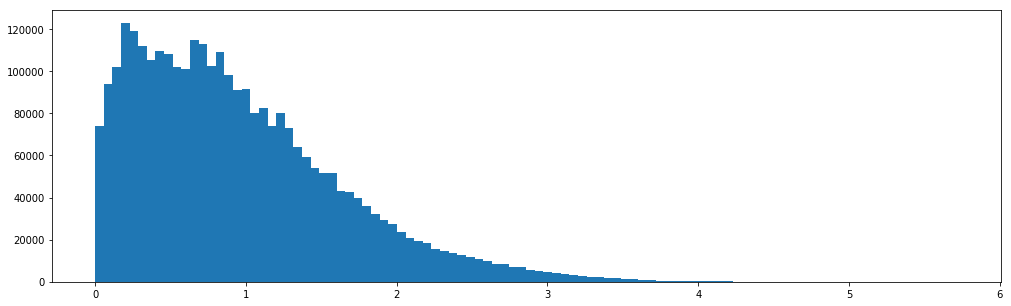

In [41]:
plt.hist(distances.reshape(-1), bins=100)
plt.show()

In [42]:
print('{} distances equal exactly zero.'.format(np.sum(distances == 0)))
print(len(distances))

2027 distances equal exactly zero.
1743


#### Weights

1743
1743
0.0
1.0


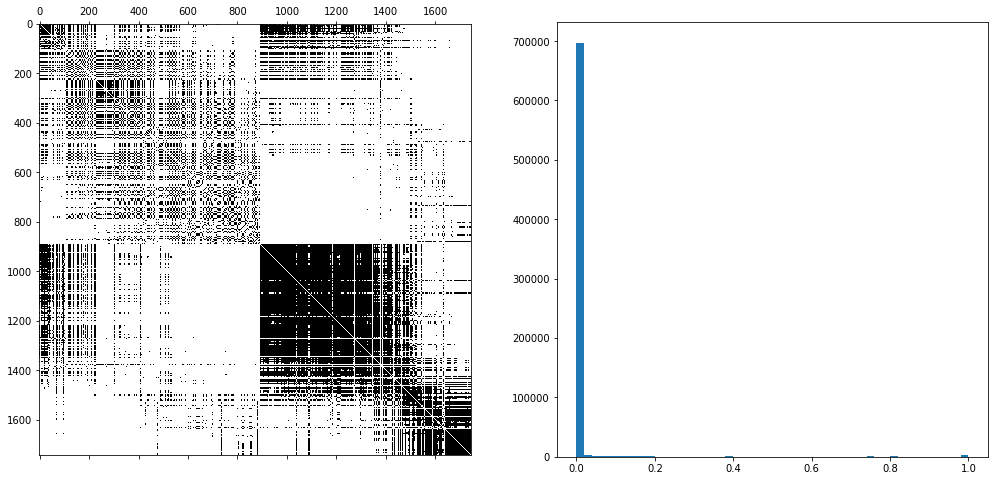

In [43]:
# We use the percentile value to set the kernel width
# It allows for more latitude than the mean and can easily be adapted
KERNEL_WIDTH_PERCENTILE = 0.5
kernel_width = np.percentile(distances, KERNEL_WIDTH_PERCENTILE)
weights = np.exp((-np.square(distances))/kernel_width**2)

# Set the diagonal weights to 0
for index in range(len(weights)):
    weights[index][index] = 0

# Validate that all the weights on the diagonal are null
print(np.sum(np.diagonal(weights)==0))
print(len(weights))
print(weights.min())
print(weights.max())

fix, axes = plt.subplots(1, 2, figsize=(17, 8))
def plot(weights, axes):
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50);
plot(weights, axes[:])

#### Sparcify

100%|██████████| 1743/1743 [00:02<00:00, 678.10it/s] 


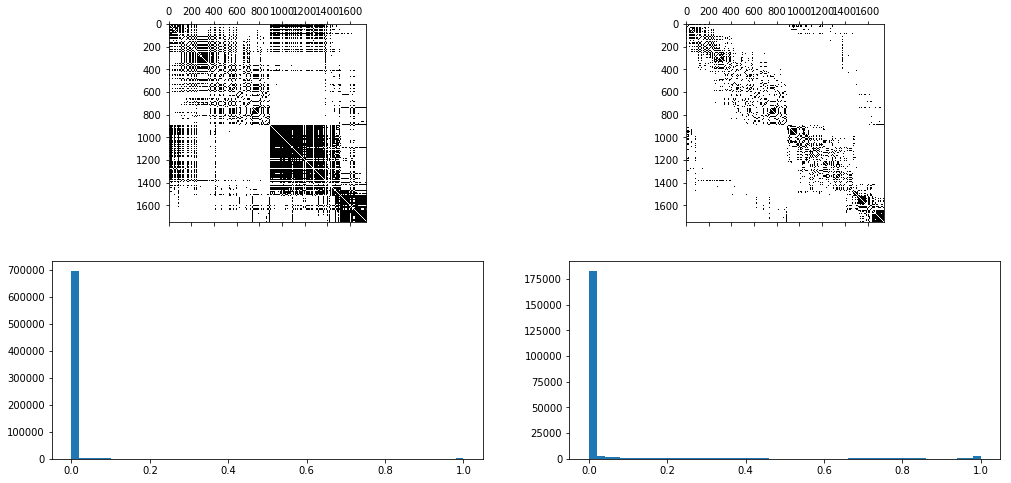

In [44]:
fix, axes = plt.subplots(2, 2, figsize=(17, 8))
def plot(weights, axes):
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50);
plot(weights, axes[:, 0])

NEIGHBORS = 100
sorted_weights_indexes = np.argsort(weights, axis=1)
epsilon = 1e-8
# Set to zero the weights that are not in the NEIGHBORS
for line in tqdm(range(len(sorted_weights_indexes))):
    for index in range(len(weights[0])-NEIGHBORS):
        weights[line][sorted_weights_indexes[line][index]] = 0.0
        

# Ensure symmetry
for i in tqdm(range(len(weights))):
    # We need to check only the bottom triangle, because we do two checks
    # This reduces significantly the loop time
    for j in range(i):
        if weights[i][j] == 0 and weights[j][i] != 0:
            weights[i][j] = weights[j][i]
            
        if weights[i][j] != 0 and weights[j][i] == 0:
            weights[j][i] = weights[i][j]
plot(weights, axes[:, 1])


In [45]:
print(weights.max())
print(weights.min())
np.isnan(weights).sum()

1.0
0.0


0

In [46]:
# Make sure that weight is symmetric
def check_symmetric(a, tol=1e-10):
    """Function to check if a is symmetric
        taken from: https://stackoverflow.com/questions/42908334/checking-if-a-matrix-is-symmetric-in-numpy
    """
    return np.allclose(a, a.T, atol=tol)

assert check_symmetric(weights), "The function is not symmetric!"

#### Graph laplacian

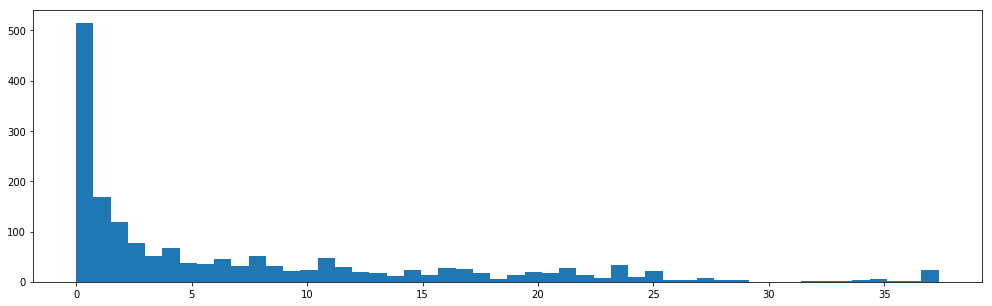

In [47]:
degrees = np.sum(weights, axis=1) 
plt.hist(degrees, bins=50);

In [48]:
# THIS IS A TEST FOR INVALID VALUES
i = 0
j = 297
print(weights[i][j], degrees[i], degrees[j])
print(type(degrees[i]))
print(type(degrees[j]))
-weights[i][j]/np.sqrt(degrees[i]*degrees[j])
print(np.sqrt(degrees[i]*degrees[j]))

0.0 2.91873066385 1.01574920953
<class 'numpy.float64'>
<class 'numpy.float64'>
1.72182994649


In [49]:
laplacian = np.zeros((len(degrees), len(degrees)))
laplacian.flags.writeable = True

for i in tqdm(range(len(degrees))):
    for j in range(len(degrees)):
        #print(i,j, flush=True)
        if i==j:
            laplacian[i][j] = 1
        else:
            square_root = np.sqrt(degrees[i]*degrees[j])
            # Avoid divide by 0
            # Check if we should put 1 or 0 here...
            if square_root == 0.0:
                laplacian[i][j] = 0.0
            else:
                laplacian[i][j] = -weights[i][j]/square_root
            
# Make sure there's no invalid value            
#laplacian = np.nan_to_num(laplacian)            
print(laplacian.max())

100%|██████████| 1743/1743 [00:07<00:00, 238.91it/s]

1.0


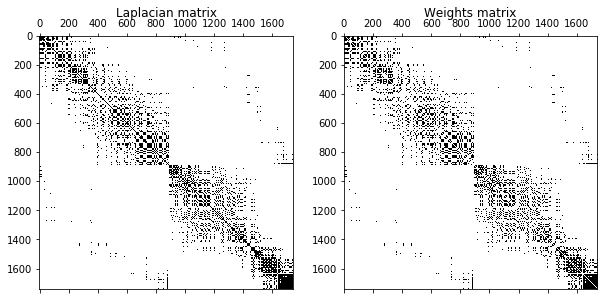

In [50]:
fix, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].spy(laplacian);
axes[0].set_title("Laplacian matrix")
axes[1].spy(weights)
axes[1].set_title("Weights matrix")
plt.show()

In [51]:
np.isnan(laplacian).any().sum()

0

In [52]:
laplacian = sparse.csr_matrix(laplacian)

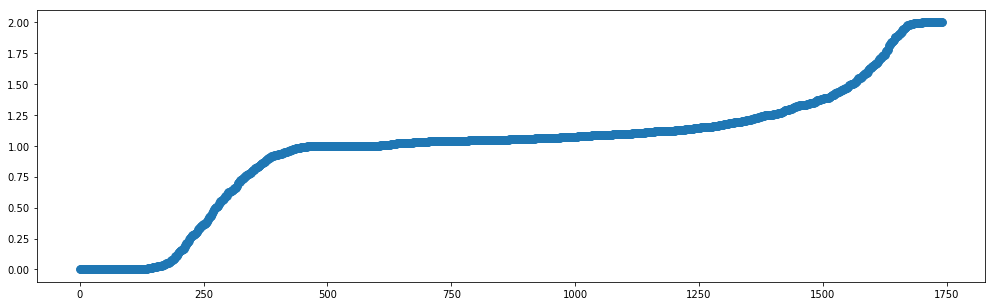

[ -7.99682041e-15  -6.35554898e-15  -4.89214013e-15 ...,   2.00000000e+00
   2.00000000e+00   2.00000000e+00]


In [53]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian,
                                                k=len(weights)-1,
                                                maxiter=100000,
                                                which='SA')
plt.plot(eigenvalues, '.-', markersize=15);
plt.show()
print(eigenvalues)

In [54]:
min_index = 0
for index, value in enumerate(eigenvalues):
    if value > 0.01:
        min_index = index
        break
print(min_index)

141


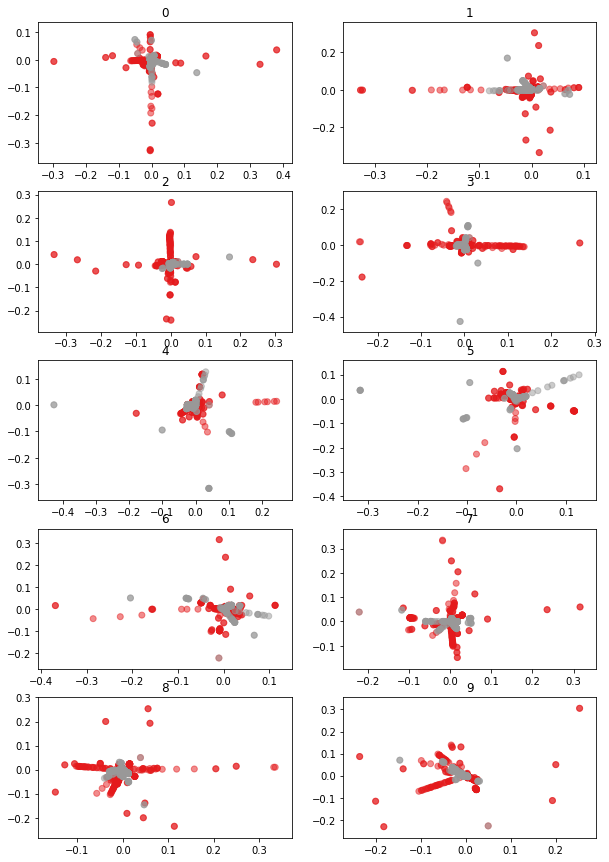

In [55]:
NBR_OF_GRAPH = 10
fig, axes = plt.subplots(NBR_OF_GRAPH//2,2,figsize=(10,15))
for index in range(NBR_OF_GRAPH):
    x = eigenvectors[:, index]
    y = eigenvectors[:, index+1]
    axes[index//2][index %2].scatter(x, y, c=label_df.launch_site.values, cmap='Set1', alpha=0.5);
    axes[index//2][index %2].set_title("{}".format(index))
plt.show()

#### Graph analysis with PyGSP

In [56]:
# Using the epsilon values avoid a division by 0 error by pyGSP
epsilon = 1e-8
for i in tqdm(range(len(weights))):
    for j in range(len(weights)):
        if i == j:
            continue
        if weights[i][j] == 0:
            weights[i][j] = epsilon

100%|██████████| 1743/1743 [00:02<00:00, 658.31it/s]


In [57]:
G = graphs.Graph(weights, gtype="Satellite weights")

In [58]:
G.compute_laplacian('normalized')

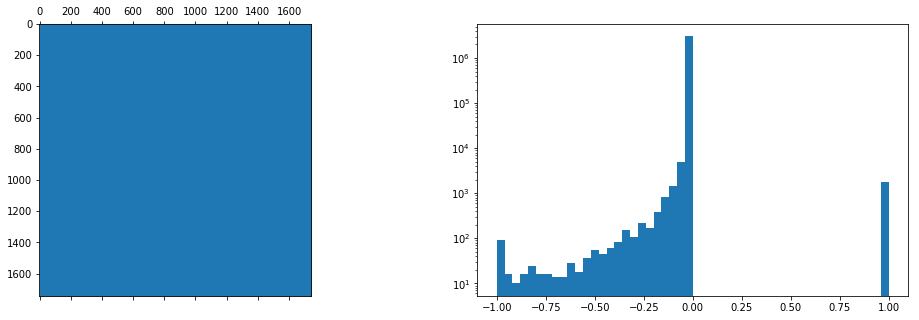

In [59]:
# Display the computed laplacian for validation
fig, axes = plt.subplots(1, 2)
axes[0].spy(G.L, markersize=0.02)
axes[1].hist(G.L.data, bins=50, log=True);

In [60]:
G.compute_fourier_basis(recompute=True)

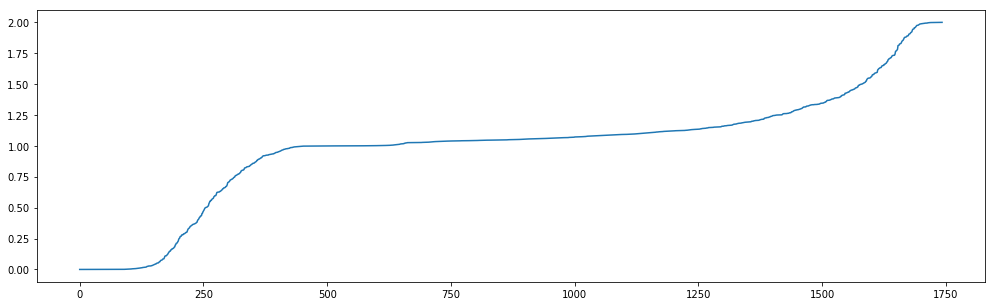

In [61]:
plt.plot(G.e);

In [62]:
for index, item in enumerate(G.e):
    if item > 0.1:
        min_index = index
        print(item)
        break
print(min_index)

0.105974217684
172


(1743, 2)


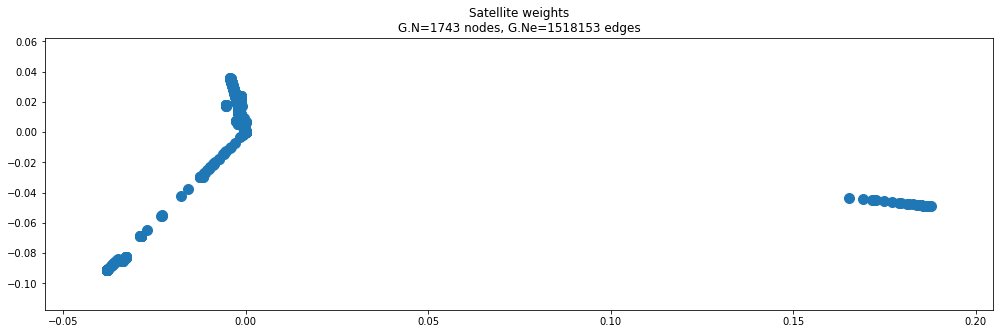

In [63]:
print(G.U[:, min_index:min_index+2].shape)
G.set_coordinates(G.U[:, 1:3])
G.plot()

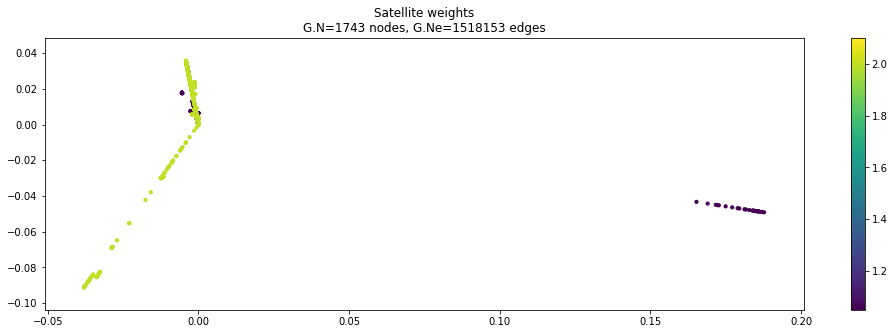

In [64]:
G.plot_signal(label_df.launch_site.values, vertex_size=10)

### Graph analysis using networkx

In [65]:
# Remove the epsilon values to avoid having a fully connected graph
epsilon = 1e-8
for i in tqdm(range(len(weights))):
    for j in range(len(weights)):
        if i == j:
            continue
        if weights[i][j] <= epsilon:
            weights[i][j] = 0.0

100%|██████████| 1743/1743 [00:02<00:00, 798.27it/s]


In [66]:
graph = nx.Graph(weights)

In [67]:
def get_nodes_per_site(graph):
    nodes_per_site = []
    for launch_site in reduced_satcat_df.launch_site.unique():
        node_names = []
        index_list = list(reduced_satcat_df[reduced_satcat_df.launch_site == launch_site].index)
        for item in index_list:
            potential_node = reduced_satcat_df.index.get_loc(item)
            # Check if node is in the graph
            if graph.has_node(potential_node):
                node_names.append(potential_node)
        nodes_per_site.append(node_names)
    return nodes_per_site

#### Draw the network

In [68]:
def draw_graph(graph):
    nodes_per_site = get_nodes_per_site(graph)
    layout = nx.spring_layout(graph)

    plt.figure(figsize=(20,10))
    for index, node in enumerate(nodes_per_site):
        nx.draw_networkx_nodes(graph,
                               layout,
                               nodes_per_site[index],
                               node_color=plt.get_cmap('Set1')(index),
                               node_size=30
                              ) 
    nx.draw_networkx_edges(graph,layout, width=0.1)
    plt.show()

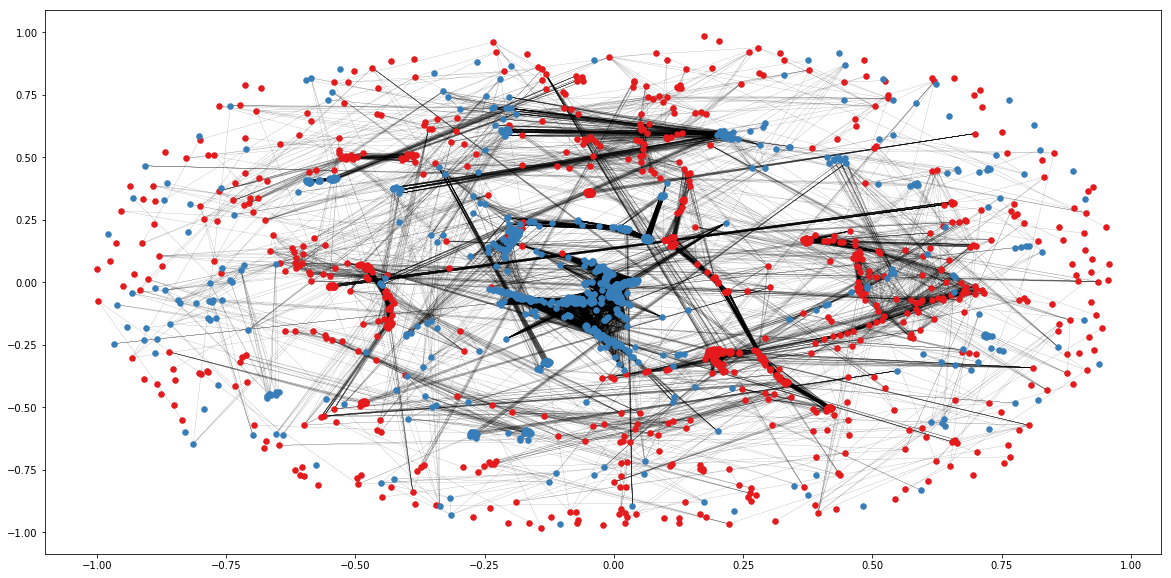

In [69]:
draw_graph(graph)

#### Filter the graph degree

We will first remove nodes with small amount of edges, because we can see that they don't really provide information on the clusters.

**NOTE:** 

    1.This is used only to remove the nodes with a degree of 0, because we want to keep small degree nodes for the next steps.
    2.We keep the code to show how we progressed through the task

In [112]:
graph = nx.Graph(weights)
# Filter out lonely nodes
MINIMUM_DEGREE = 0 
nodes_to_drop = []
for node in tqdm(graph.nodes):
    if graph.degree(node) <= MINIMUM_DEGREE:
        nodes_to_drop.append(node)
graph.remove_nodes_from(nodes_to_drop)      
print(len(graph.nodes))

100%|██████████| 1743/1743 [00:00<00:00, 349024.72it/s]

1631


In [113]:
# Do it again to remove resulting node with degree of 0
for node in tqdm(graph.nodes):
    if graph.degree(node) == 0:
        nodes_to_drop.append(node)
graph.remove_nodes_from(nodes_to_drop) 
print(len(graph.nodes))

100%|██████████| 1631/1631 [00:00<00:00, 335585.47it/s]

1631


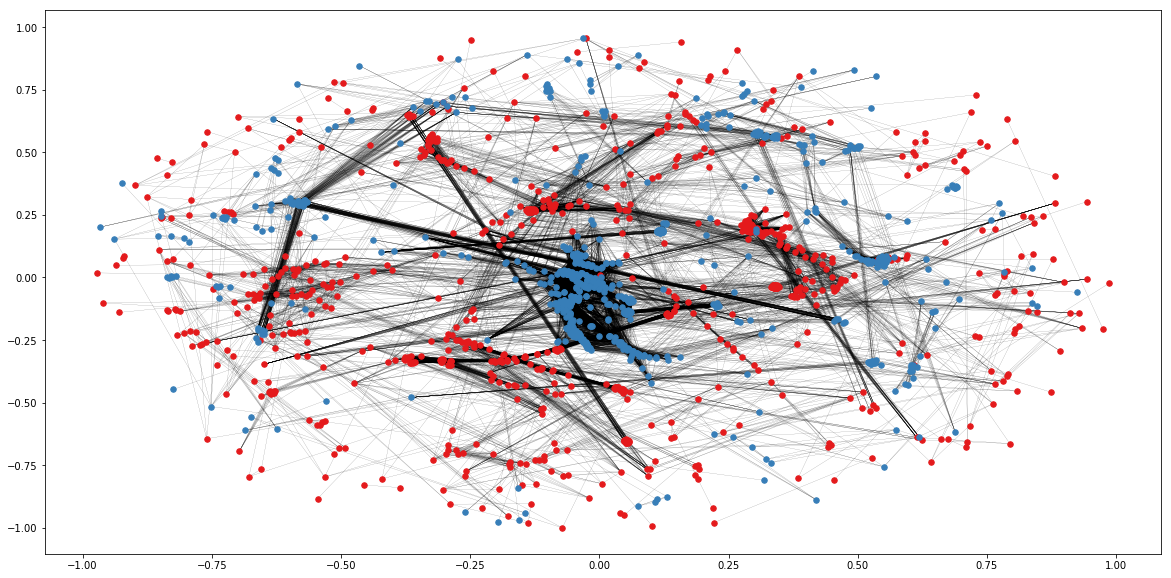

In [114]:
draw_graph(graph)

We can see that there's clearly some major clusters appearing in the graph. 
The next step will be to attempt to segregate those clusters and extract see if we can identify they came from which launch site, and to which precision we can identify them.

##### Separate the graph in connected subgraphs

In [115]:
connected_subgraphs = []
for subgraph in  nx.connected_component_subgraphs(graph):
    connected_subgraphs.append(nx.Graph(subgraph))
print(len(connected_subgraphs))

57


In [116]:
def get_nodes_nbr(graphs):
    return [len(graph.nodes) for graph in graphs] 

In [117]:
# Check the properties of the generated graphs 
def print_subgraphs_nodes_dist(subgraphs):
    fig, axes = plt.subplots(1, 1, figsize=(5,3))
    nodes_nbr = get_nodes_nbr(subgraphs)
    print(nodes_nbr)
    sns.distplot(nodes_nbr,kde=False, rug=True, ax=axes);
    plt.show()

[670, 14, 6, 6, 136, 5, 2, 6, 2, 169, 96, 6, 2, 2, 5, 40, 7, 2, 2, 2, 4, 2, 43, 23, 39, 5, 2, 2, 2, 7, 2, 31, 28, 2, 2, 3, 2, 2, 2, 17, 4, 2, 4, 5, 3, 4, 8, 5, 6, 4, 27, 5, 131, 6, 3, 10, 4]


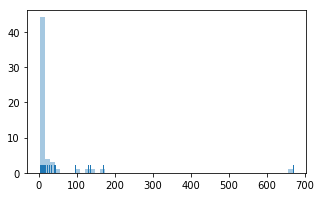

In [118]:
print_subgraphs_nodes_dist(connected_subgraphs)

We node that there's a lot of small graphs, without many nodes.
There's no real way for us to identify those small nodes, so we will aim bigger, putting a minimal value for the number of nodes in the analyzed subgraphs.
We use a visual analysis and chose to filter above 50 nodes in the subgraph.

In [119]:
nodes_nbr = get_nodes_nbr(connected_subgraphs)
MINIMUM_NBR_OF_NODES = np.percentile(nodes_nbr,
                                     60)
kept_subgraphs = [connected_subgraphs[index] for index, val in enumerate(nodes_nbr) if val >= MINIMUM_NBR_OF_NODES]
print(len(kept_subgraphs))

24


[670, 14, 6, 6, 136, 6, 169, 96, 6, 40, 7, 43, 23, 39, 7, 31, 28, 17, 8, 6, 27, 131, 6, 10]


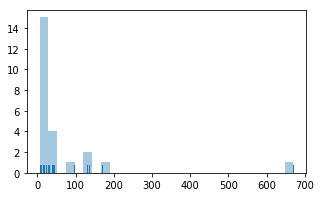

In [120]:
print_subgraphs_nodes_dist(kept_subgraphs)

In [121]:
def print_subgraphs_network(subgraphs):
    nbr_of_graphs = len(subgraphs)
    
    fig, axes = plt.subplots(nbr_of_graphs//2,2, figsize=(20,20))
    
    for graph_index,graph in enumerate(subgraphs):
        nodes_per_site = get_nodes_per_site(graph)
        layout = nx.spring_layout(graph)

        for node_index, node in enumerate(nodes_per_site):
            nx.draw_networkx_nodes(graph,
                                   layout,
                                   nodes_per_site[node_index],
                                   node_color=plt.get_cmap('Set1')(node_index),
                                   node_size=30,
                                   ax=axes[graph_index//2][graph_index%2]
                                  ) 
        nx.draw_networkx_edges(graph,layout, width=0.1, ax=axes[graph_index//2][graph_index%2])
    plt.show()

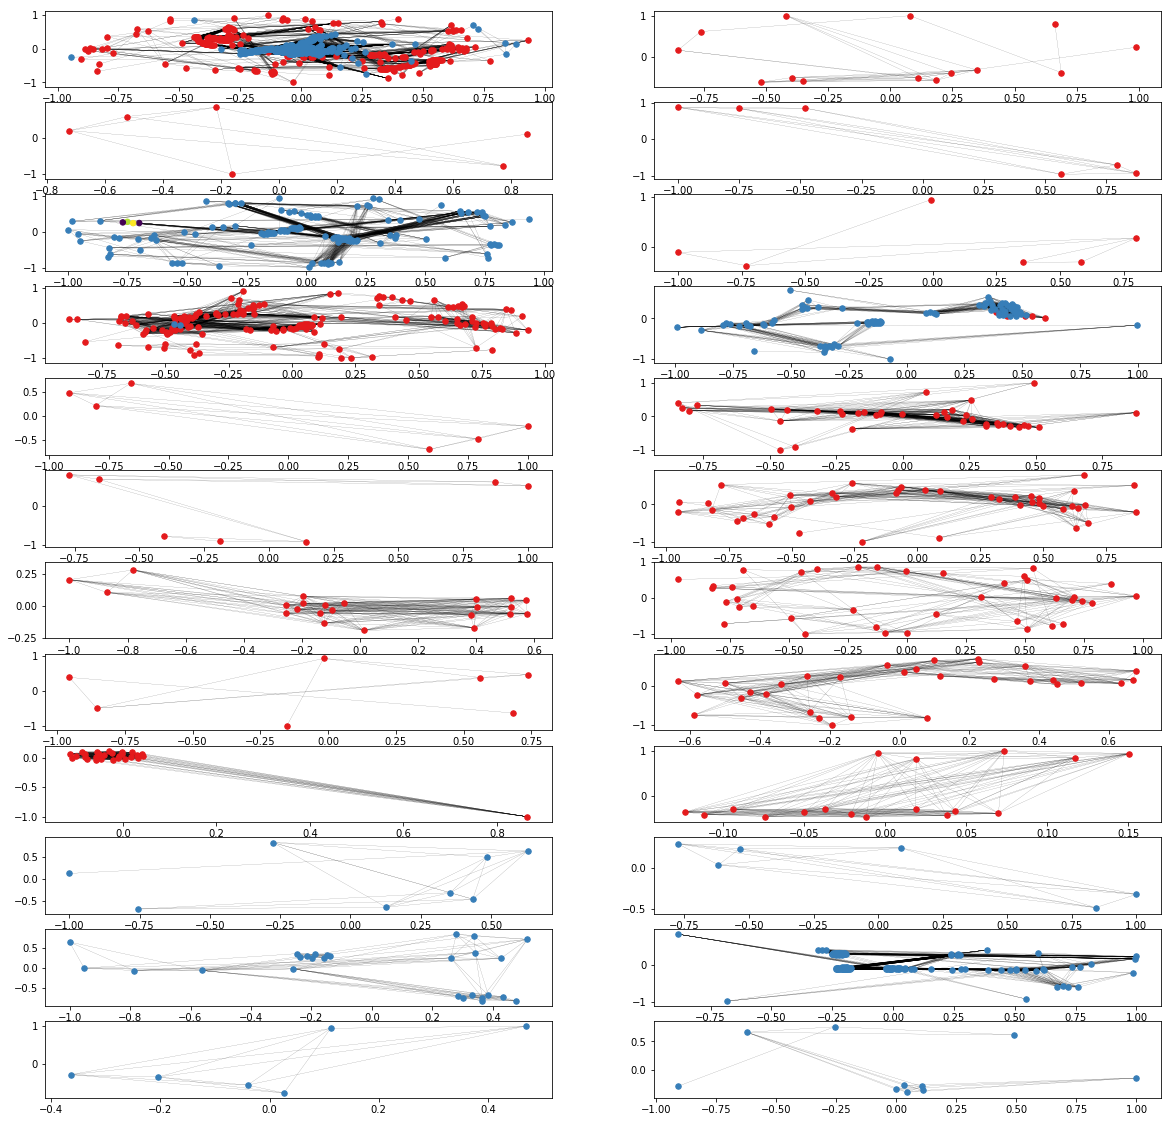

In [122]:
print_subgraphs_network(kept_subgraphs)

In [123]:
# TODO: check why some nodes are yellow and black....

##### Separate the biggest graph in subgraphs

We see from the result above that most subgraphs are well separated but for the largest subgraph.

To improve the results, we will separate the bigger subgraph into smaller ones.

To determine how we will end the separation, we will use the 
*Highly Connected Clusters/Components/Kernels* ([HCS](https://en.wikipedia.org/wiki/HCS_clustering_algorithm))  clustering algorithm

In [124]:
NUMBER_OF_BIG_SUBGRAPHS_TO_PROCESS = 1

# Get the index of the big subgraphs
subgraphs_nbr_dict = {len(subgraph.nodes):index for index, subgraph in enumerate(kept_subgraphs)}
subgraphs_nbr = list(subgraphs_nbr_dict.keys())
subgraphs_nbr = np.array(subgraphs_nbr).argsort()[-NUMBER_OF_BIG_SUBGRAPHS_TO_PROCESS:]

In [125]:
print(type(graph))

<class 'networkx.classes.graph.Graph'>


In [126]:
current_subgraph = kept_subgraphs[0]
print(len(current_subgraph.nodes))
print(len(current_subgraph.edges))
print(nx.edge_connectivity(current_subgraph))
nx.minimum_edge_cut(current_subgraph)

670
24635
1


{(1279, 1379)}

In [127]:
def HCS(graph):
    """ 
        This function implement the Highly Connected Clusters/Components/Kernels algorithm
        see: (https://en.wikipedia.org/wiki/HCS_clustering_algorithm)
        
    """
    connectivity = nx.edge_connectivity(graph)
    #connectivity = nx.node_connectivity(graph)
    target = len(graph.nodes)//2
    print("Entering HCS, connectivity: {}, target: {}".format(connectivity, target))
    if  connectivity > target:
        return graph
    else:
        # Minimum cut
        #edges_to_remove = nx.minimum_edge_cut(graph)
        #graph.remove_edges_from(edges_to_remove)
        print("doing_all_node_cut")
        nodes_to_remove = nx.all_node_cuts(graph)
        graph.remove_nodes_from(nodes_to_remove)
        subgraphs = []
        for subgraph in  nx.connected_component_subgraphs(graph):
            resulting_graph = HCS(nx.Graph(subgraph))
            if type(resulting_graph) is nx.Graph:
                subgraphs.append(resulting_graph)
            else:
                for graph in resulting_graph:
                    subgraphs.append(graph)
        return subgraphs

In [128]:
subgraphs = []
for subgraph_index in subgraphs_nbr:
    current_subgraph = kept_subgraphs[subgraph_index].copy()
    #subgraphs.append(HCS(current_subgraph))

##### Attempt another solution

The HCS algorithm is overkill for our situation.
It finds subgraphs that are too small and, in addition, it
takes a long time to run.
Instead, we will simply do a minimum cut

In [142]:
subgraphs = []
for subgraph_index in subgraphs_nbr:
    current_subgraph = kept_subgraphs[subgraph_index].copy()
    cutsets = nx.all_node_cuts(current_subgraph)
    #for cut in cutsets:
    #    subgraphs.append(nx.Graph(cut))

In [143]:
temp_graph = current_subgraph.copy()

In [144]:
print(len(temp_graph.nodes))
cut_list = []
for cutset in cutsets:
    print(cutset)
    temp_graph.remove_nodes_from([cut in cutset])
print(len(temp_graph.nodes))

{270}
{285}
{298}
{423}
{1279}
{1461}


In [145]:
temp_subgraphs = []
for subgraph in  nx.connected_component_subgraphs(temp_graph):
    temp_subgraphs.append(nx.Graph(subgraph))

In [146]:
print_subgraphs_network(temp_subgraphs)

IndexError: index out of range